In [39]:
import torch as tc
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision as tv
from torchvision import models, transforms, datasets

from PIL import Image

In [4]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
model = models.segmentation.deeplabv3_resnet50(True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 80.4MB/s]


In [5]:
model = model.to(device)

In [6]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [10]:
model.eval()
with tc.no_grad():
  out = model(tc.randn(size = (1, 3, 1024, 2048)).to(device))

In [15]:
out['out'].shape, out['aux'].shape

(torch.Size([1, 21, 1024, 2048]), torch.Size([1, 21, 1024, 2048]))

In [19]:
train_dataset = datasets.VOCSegmentation('/content/', '2012', 'train', True)

Using downloaded and verified file: /content/VOCtrainval_11-May-2012.tar
Extracting /content/VOCtrainval_11-May-2012.tar to /content/


In [20]:
valid_dataset = datasets.VOCSegmentation('/content/', '2012', 'val', True)

Using downloaded and verified file: /content/VOCtrainval_11-May-2012.tar
Extracting /content/VOCtrainval_11-May-2012.tar to /content/


In [21]:
len(train_dataset), len(valid_dataset)

(1464, 1449)

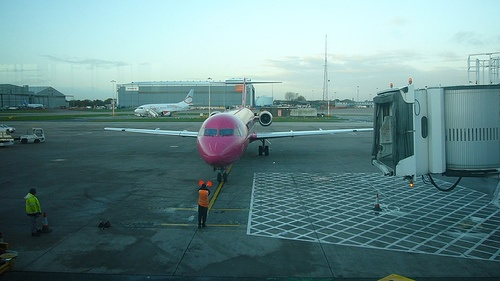

In [23]:
train_dataset[0][0]

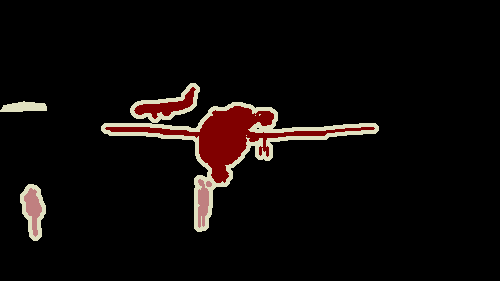

In [24]:
train_dataset[0][1]

In [25]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

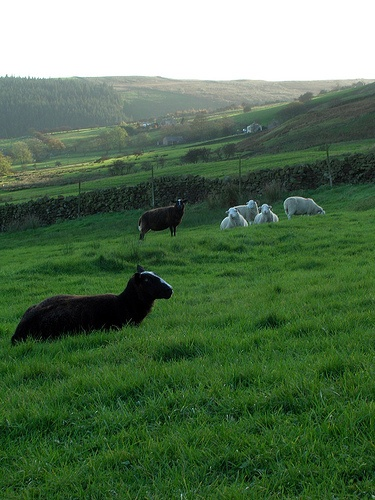

In [85]:
index = tc.randint(len(train_dataset), (1, ))
image, mask = train_dataset[index]
display(image)

image_tensor = train_transforms(image).unsqueeze(0).to(device)

In [86]:
model.eval()
with tc.no_grad():
  out = model(image_tensor)

In [87]:
pred = out['out'][0].argmax(dim = 0)

In [88]:
pred

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [89]:
# create a color pallette, selecting a color for each class
palette = tc.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = tc.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")
colors

array([[  0,   0,   0],
       [  1, 127,  31],
       [  2, 254,  62],
       [  3, 126,  93],
       [  4, 253, 124],
       [  5, 125, 155],
       [  6, 252, 186],
       [  7, 124, 217],
       [  8, 251, 248],
       [  9, 123,  24],
       [ 10, 250,  55],
       [ 11, 122,  86],
       [ 12, 249, 117],
       [ 13, 121, 148],
       [ 14, 248, 179],
       [ 15, 120, 210],
       [ 16, 247, 241],
       [ 17, 119,  17],
       [ 18, 246,  48],
       [ 19, 118,  79],
       [ 20, 245, 110]], dtype=uint8)

In [90]:
#pred = tc.tensor(pred, dtype = tc.int32)

In [94]:
#mask = transforms.ToPILImage()(pred.byte())
mask_pred  = Image.fromarray(pred.byte().cpu().numpy()).resize(image.size)
mask_pred.putpalette(colors)

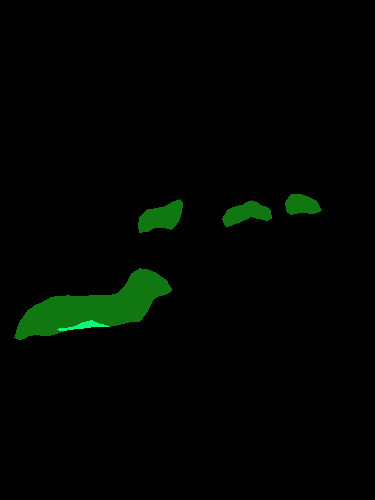

In [95]:
display(mask_pred)

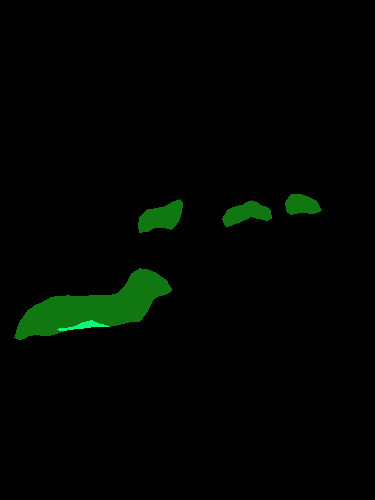

In [96]:
mask

#Train

In [97]:
!git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 362594, done.
remote: Counting objects: 100% (12834/12834), done.
remote: Compressing objects: 100% (888/888), done.
remote: Total 362594 (delta 11946), reused 12693 (delta 11876), pack-reused 349760
Receiving objects: 100% (362594/362594), 723.48 MiB | 24.70 MiB/s, done.
Resolving deltas: 100% (334494/334494), done.


In [98]:
cd vision

/content/vision


In [101]:
%%shell

cp /content/vision/references/segmentation/utils.py ../
cp /content/vision/references/segmentation/train.py ../
cp /content/vision/references/segmentation/presets.py ../
cp /content/vision/references/segmentation/transforms.py ../
cp /content/vision/references/segmentation/coco_utils.py ../

In [106]:
cd /content/

/content


In [107]:
!python train.py --help

usage: train.py
       [-h]
       [--data-path DATA_PATH]
       [--dataset DATASET]
       [--model MODEL]
       [--aux-loss]
       [--device DEVICE]
       [-b BATCH_SIZE]
       [--epochs N]
       [-j N]
       [--lr LR]
       [--momentum M]
       [--wd W]
       [--lr-warmup-epochs LR_WARMUP_EPOCHS]
       [--lr-warmup-method LR_WARMUP_METHOD]
       [--lr-warmup-decay LR_WARMUP_DECAY]
       [--print-freq PRINT_FREQ]
       [--output-dir OUTPUT_DIR]
       [--resume RESUME]
       [--start-epoch N]
       [--test-only]
       [--use-deterministic-algorithms]
       [--world-size WORLD_SIZE]
       [--dist-url DIST_URL]
       [--weights WEIGHTS]
       [--weights-backbone WEIGHTS_BACKBONE]
       [--amp]
       [--backend BACKEND]
       [--use-v2]

PyTorch Seg
mentation
Training

options:
  -h, --help
    show this
    help
    message and
    exit
  --data-path DATA_PATH
    dataset
    path
  --dataset DATASET
    dataset
    name
  --model MODEL
    model name
  --aux-lo

In [125]:
!python train.py --lr 0.001 --dataset voc --data-path /content/  -b 4 --model deeplabv3_resnet50 --aux-loss --weights-backbone ResNet50_Weights.IMAGENET1K_V1

Not using distributed mode
Namespace(data_path='/content/', dataset='voc', model='deeplabv3_resnet50', aux_loss=True, device='cuda', batch_size=4, epochs=30, workers=16, lr=0.001, momentum=0.9, weight_decay=0.0001, lr_warmup_epochs=0, lr_warmup_method='linear', lr_warmup_decay=0.01, print_freq=10, output_dir='.', resume='', start_epoch=0, test_only=False, use_deterministic_algorithms=False, world_size=1, dist_url='env://', weights=None, weights_backbone='ResNet50_Weights.IMAGENET1K_V1', amp=False, backend='pil', use_v2=False, distributed=False)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings